In [1]:
# Wang, Jixin et al. “Pan-Cancer Proteomics Analysis to Identify Tumor-Enriched and Highly Expressed Cell Surface Antigens as Potential Targets for Cancer Therapeutics.”
# Molecular & cellular proteomics : MCP vol. 22,9 (2023)
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10494184/
# https://zenodo.org/records/7991979

In [2]:
# CPTAC_FragPipe_DEG_v01
# Alberto Bejarano 2024
#!pip3 install adjustText

In [3]:
# intensity-based absolute quantification (iBAQ)
# total protein approach (TPA)
# tandem mass tag (TMT) 
# TMT-TPA
# TMT-iBAQ

In [4]:
import time; start = time.time()
from datetime import datetime; print(datetime.now().strftime("%B %d, %Y %H:%M:%S"))

May 27, 2024 20:54:54


In [5]:
import pandas as pd
pd.set_option('display.max_columns', 200 )
pd.set_option('display.precision',   2   )
pd.set_option('display.width',       1000)
#        -         -        -        -         -        -         -        -        -         -
from matplotlib.ticker import SymmetricalLogLocator, NullFormatter
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
from adjustText import adjust_text
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pyreadr
import re, glob, os
#        -         -        -        -         -        -         -        -        -         -
import warnings; warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [6]:
filter = "Global"; n = 50
filter = "CancerType"; n = 10

In [7]:
datasetss =[
            ('cptac_brca_tumor_vs_normal_list',  'BRCA'),
            #('cptac_ccrcc_tumor_vs_normal_list', 'ccRCC'),
            ('cptac_coad_tumor_vs_normal_list',  'COAD'),
            ('cptac_gbm_tumor_vs_normal_list',   'GBM'),
            ('cptac_hnscc_tumor_vs_normal_list', 'HNSCC'),
            ('cptac_lscc_tumor_vs_normal_list',  'LSCC'),
            ('cptac_luad_tumor_vs_normal_list',  'LUAD'),
            ('cptac_ov_tumor_vs_normal_list',    'OV'),
            ('cptac_pda_tumor_vs_normal_list',   'PDA'),
            ('cptac_ucec_tumor_vs_normal_list',  'UCEC')
           ]

In [8]:
GenesOfInterest = ['MSLN', 'RAB5A', 'RAB5B', 'ERBB3', 'ERBB2', 'CTLA4']

In [9]:
GenesOfInterest = ['NDUFA4L2', 'NNMT', 'PLIN2', 'SEMA5B', 'FCER1G', 'RHCE', 'RAB42', 'S100A2', 'CA9', 'SLC16A3', 'SCGN', 'FABP7', 'TYROBP', 'ENO2',
                   'CD70', 'HAPLN1', 'PLOD2', 'SPRR4', 'HK2', 'RAD51B', 'FTL', 'AHNAK2', 'SLC2A1', 'ILDR1', 'FAM246A', 'HBE1', 'INTU', 'PFKP', 'KRT74',
                   'FTH1', 'PYGL', 'DEFB112', 'ACKR3', 'FABP6', 'COL23A1', 'SERPINB5', 'NT5DC3', 'SDS', 'L1RE1', 'MMP1', 'SCARB1', 'HAVCR1', 'CTHRC1',
                   'ITGAX', 'PNMA2', 'CYP2J2', 'IKBIP', 'SLC2A3', 'NOL3', 'FCGR3A']

In [10]:
%%time
#        -         -        -        -         -        -         -        -        -         -        -         -
src_path = './data/DEG/'; DEprot_exp = []
#        -         -        -        -         -        -         -        -        -         -        -         -
for file, tumortype in datasetss:
    df = pd.read_csv(src_path + file+'.csv', header=0, sep=',', quotechar='"', on_bad_lines='warn')
    cols = {'ID': 'GeneSymbol'}; df.rename(columns=cols, inplace=True)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    df["TumorType"] = tumortype
    df.sort_values(by=['logFC'], ascending=[False], inplace=True); #df=df.head(n)
    df = df[df["GeneSymbol"].isin(GenesOfInterest)]
    try:
        DEprot_exp.append(df)
    except:
        print("An exception occurred")
#        -         -        -        -         -        -         -        -        -         -        -         -        
DEprot_exp_df = pd.concat(DEprot_exp, ignore_index=True)

CPU times: total: 266 ms
Wall time: 267 ms


In [11]:
DEprot_exp_df.sort_values(by=['logFC'], ascending=[False], inplace = True)

In [12]:
DEprot_exp_df['log10_adjPVal'] = DEprot_exp_df['adj.P.Val'].apply(lambda x: -np.log(x))
DEprot_exp_df.head()

,GeneSymbol,logFC,AveExpr,t,P.Value,adj.P.Val,B,TumorType,log10_adjPVal
147,S100A2,2.21,27.47,12.51,2.69e-27,9.70e-27,50.76,LSCC,59.90
108,SPRR4,2.03,22.68,6.34,2.09e-09,7.13e-09,10.50,HNSCC,18.76
109,RAD51B,2.01,24.36,14.22,1.37e-30,5.55e-29,58.85,HNSCC,65.06
110,ILDR1,1.97,24.00,10.17,3.32e-19,3.37e-18,32.78,HNSCC,40.23
190,DEFB112,1.85,21.72,11.24,2.15e-23,7.86e-23,41.88,LUAD,50.90


In [13]:
len(DEprot_exp_df)

333

In [14]:
df2 = DEprot_exp_df[0:50]
df2['index'] = range(0, len(df2))
df2.head(10)

,GeneSymbol,logFC,AveExpr,t,P.Value,adj.P.Val,B,TumorType,log10_adjPVal,index
147,S100A2,2.21,27.47,12.51,2.69e-27,9.70e-27,50.76,LSCC,59.90,0
108,SPRR4,2.03,22.68,6.34,2.09e-09,7.13e-09,10.50,HNSCC,18.76,1
109,RAD51B,2.01,24.36,14.22,1.37e-30,5.55e-29,58.85,HNSCC,65.06,2
110,ILDR1,1.97,24.00,10.17,3.32e-19,3.37e-18,32.78,HNSCC,40.23,3
190,DEFB112,1.85,21.72,11.24,2.15e-23,7.86e-23,41.88,LUAD,50.90,4
148,ACKR3,1.84,18.11,13.62,8.29e-31,3.46e-30,58.83,LSCC,67.84,5
149,SERPINB5,1.81,26.19,15.13,1.29e-35,6.65e-35,69.88,LSCC,78.70,6
150,L1RE1,1.79,24.10,18.67,1.01e-46,9.16e-46,95.43,LSCC,103.70,7
111,MMP1,1.78,27.29,12.29,3.97e-25,8.02e-24,46.33,HNSCC,53.18,8
151,CTHRC1,1.74,24.10,19.90,1.73e-50,1.97e-49,104.10,LSCC,112.15,9


In [15]:
GenesOfInterest = DEprot_exp_df.GeneSymbol.tolist()
print(GenesOfInterest[:10])

['S100A2', 'SPRR4', 'RAD51B', 'ILDR1', 'DEFB112', 'ACKR3', 'SERPINB5', 'L1RE1', 'MMP1', 'CTHRC1']


In [16]:
palette = sns.color_palette("pastel")
#kws1 = {'s':20, 'alpha':0.25, 'linewidth':0.5,'edgecolor':'#1E1E1E', 'palette':palette}
scatter_kws = {'s':10, 'alpha':0.25, 'edgecolor':'#1E1E1E'}; line_kas= {'color': 'red', 'alpha':0.25, 'lw':1};

['S100A2' 'SPRR4' 'RAD51B' 'ILDR1' 'DEFB112' 'ACKR3' 'SERPINB5' 'L1RE1'
 'MMP1' 'CTHRC1']


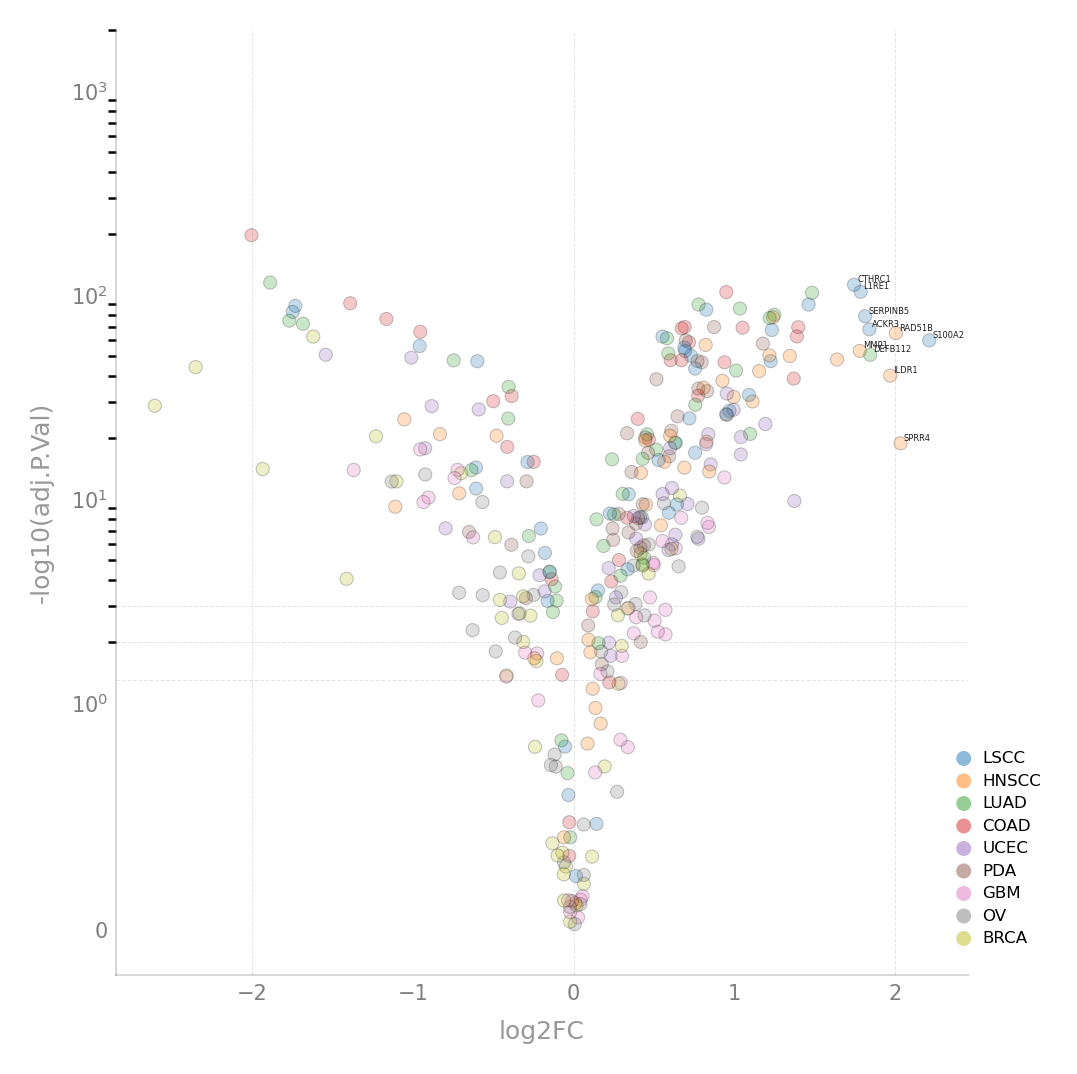

In [17]:
figsize=(10/2.54, 10/2.54); fig, ax = plt.subplots(figsize=figsize, dpi=300)
#          -          -          -          -          -          -          -          -          -          -          -          -          -          -     
sns.scatterplot(data=DEprot_exp_df, x="logFC", y="log10_adjPVal", hue='TumorType', **scatter_kws)
#          -          -          -          -          -          -          -          -          -          -          -          -          -          -        
types = df2.reset_index()['GeneSymbol'].values; types=types[:10]; print(types)
x = df2['logFC'].values; y = df2['log10_adjPVal'].values;
def check_overlap(x1, y1, x2, y2):
    #if x1 < x2 + 0.5 and x1 + 0.5 > x2 and y1 < y2 + 0.5 and y1 + 0.5 > y2:
    if x1 < x2 + 0.6 and x1 + 0.6 > x2 and y1 < y2 + 0.6 and y1 + 0.6 > y2:
        return True
    return False
for i, txt in enumerate(types):
    kws = {'fontsize':2, 'color':'#1E1E1E', 'weight':300}
    while any(check_overlap(x[i], y[i], x[j], y[j]) for j in range(i)):
        y[i] += 1  # Offset for adjustment
    ax.annotate(txt, (x[i], y[i]), xytext=(3, 3), textcoords='offset pixels', **kws)
#          -          -          -          -          -          -          -          -          -          -          -          -          -          - 
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('#7E7E7E'); ax.spines[spine].set_alpha(0.3);
    ax.spines[spine].set_linewidth(0.5)
#          -          -          -          -          -          -          -          -          -          -          -          -          -          - 
axlabelkws = {'fontsize':6, 'color':'#7E7E7E', 'alpha':0.8, 'labelpad':4}
plt.xlabel("log2FC", **axlabelkws); plt.ylabel("-log10(adj.P.Val)", **axlabelkws)
ax.tick_params(axis="x", which='major', colors="#cfcfcf", length=0, width=0, pad=2)
ax.tick_params(axis='y', which='major', colors="#cfcfcf", length=0, width=0, pad=2)
#ax.tick_params(axis='y', which='minor', colors="#cfcfcf", length=0, width=0, pad=2)
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=5, color="#7E7E7E", rotation=0, rotation_mode='default')
plt.setp(ax.yaxis.get_majorticklabels(), fontsize=5, color="#7E7E7E", rotation=0, rotation_mode='default')
#          -          -          -          -          -          -          -          -          -          -          -          -          -          - 
kws_l = {"ls":"--", "alpha":0.2, "linewidth":0.25, 'color':"#7E7E7E"}
plt.axvline(x=0, **kws_l);plt.axvline(x=-2, **kws_l);plt.axvline(x=2, **kws_l)
plt.axhline(y=1.3, **kws_l);plt.axhline(y=2, **kws_l);plt.axhline(y=3, **kws_l);
#          -          -          -          -          -          -          -          -          -          -          -          -          -          - 
plt.yscale('symlog', linthresh=1); plt.ylim(-0.2, 2E3) 
ax.yaxis.set_major_locator(SymmetricalLogLocator(base=10, subs=[1.0], linthresh=1))
ax.yaxis.set_minor_locator(SymmetricalLogLocator(base=10, subs=np.arange(1, 10), linthresh=1))
#plt.grid(True, which='both', linestyle='--', linewidth=0.1)
#          -          -          -          -          -          -          -          -          -          -          -          -          -          - 
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(handles[0:12], labels[0:12], fontsize=4, markerscale=0.6, labelspacing=.45, handletextpad=0.1,
                    frameon=True, borderaxespad=0.9, facecolor="#FFFFFF", edgecolor="#FFFFFF", bbox_to_anchor=(0.95, 0.26), loc=0)
for handle in legend.legendHandles:
    handle.set_alpha(0.5); handle.set_edgecolor('none')
#plt.legend([],[],frameon=False)
#          -          -          -          -          -          -          -          -          -          -          -          -          -          - 
#plt.subplots_adjust(bottom=0.2, top=0.9, left=0.2, right=0.9)
plt.tight_layout(pad=2)
plt.show(); #plt.close()
#plt.savefig("tcga.png", format="png", bbox_inches="tight", dpi=300)

In [18]:
print("'CPTAC_FragPipe_DEG_Volcano_v01' script run time:", f'{time.time()-start:.0f}', "seconds.")

'CPTAC_FragPipe_DEG_Volcano_v01' script run time: 5 seconds.


['S100A2' 'SPRR4' 'RAD51B' 'ILDR1' 'DEFB112' 'ACKR3' 'SERPINB5' 'L1RE1'
 'MMP1' 'CTHRC1' 'CTHRC1' 'CTHRC1' 'PLOD2' 'CTHRC1' 'RAD51B' 'S100A2'
 'SERPINB5' 'FCER1G' 'PLOD2' 'IKBIP']


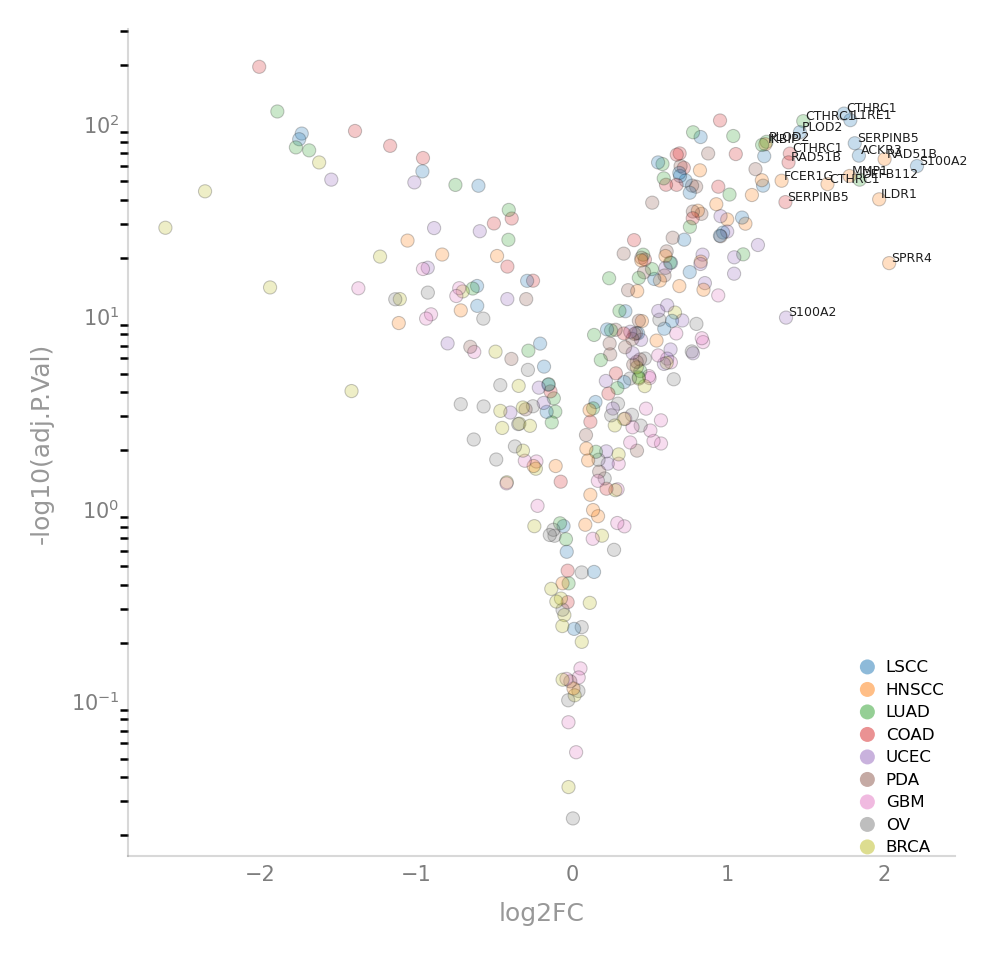

In [19]:
figsize=(10/2.54, 10/2.54); fig, ax = plt.subplots(figsize=figsize, dpi=300)
#          -          -          -          -          -          -          -          -          -          -          -          -          -          -     
sns.scatterplot(data=DEprot_exp_df, x="logFC", y="log10_adjPVal", hue='TumorType', **scatter_kws)
#plt.gca().set_yscale('log')
plt.yscale('log') 
#          -          -          -          -          -          -          -          -          -          -          -          -          -          -        
types = df2.reset_index()['GeneSymbol'].values; types=types[:20]; print(types)
x = df2['logFC'].values; y = df2['log10_adjPVal'].values;
for i, txt in enumerate(types):
    #print(i); print(txt)
    kws = {'fontsize':3, 'color':'#1E1E1E', 'weight':300}
    #ax.annotate(txt, (x[i], y[i]), xytext=(5, 5), textcoords='offset pixels', **kws)
    #ax.annotate(txt, (x[i], y[i]), xytext=figsize, textcoords='offset pixels', **kws)
    ax.annotate(txt, (x[i], y[i]), xytext=(2, 2), textcoords='offset pixels', 
                bbox=dict(facecolor='none', edgecolor='none', boxstyle='round, pad=0.5'), **kws)
#          -          -          -          -          -          -          -          -          -          -          -          -          -          - 
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('#7E7E7E'); ax.spines[spine].set_alpha(0.3);
    ax.spines[spine].set_linewidth(0.5)
#          -          -          -          -          -          -          -          -          -          -          -          -          -          - 
axlabelkws = {'fontsize':6, 'color':'#7E7E7E', 'alpha':0.8, 'labelpad':4}
plt.xlabel("log2FC", **axlabelkws); plt.ylabel("-log10(adj.P.Val)", **axlabelkws)
ax.tick_params(axis="x", which='major', colors="#cfcfcf", length=0, width=0, pad=2)
ax.tick_params(axis='y', which='major', colors="#cfcfcf", length=0, width=0, pad=2)
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=5, color="#7E7E7E", rotation=0, rotation_mode='default')
plt.setp(ax.yaxis.get_majorticklabels(), fontsize=5, color="#7E7E7E", rotation=0, rotation_mode='default')
#          -          -          -          -          -          -          -          -          -          -          -          -          -          - 
handles, labels = ax.get_legend_handles_labels()

legend = plt.legend(handles[0:12], labels[0:12], fontsize=4, markerscale=0.6, labelspacing=.45, handletextpad=0.1,
                    frameon=False, borderaxespad=0.2, facecolor="white", edgecolor="#f6f6f6", bbox_to_anchor=(1, 0.25), loc=0)
for handle in legend.legendHandles:
    handle.set_alpha(0.5); handle.set_edgecolor('none')
#plt.legend([],[],frameon=False)
#plt.tight_layout(pad=2)
plt.subplots_adjust(bottom=0.2, top=0.9, left=0.2, right=0.9) 
plt.show(); #plt.close()
#plt.savefig("tcga.png", format="png", bbox_inches="tight", dpi=300)

In [ ]:
print("'CPTAC_FragPipe_DEG_Volcano_v01' script run time:", f'{time.time()-start:.0f}', "seconds.")